# Understanding UCI HAR Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load all data
train_paths = ["./UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt",\
            "./UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt"]
body_acc_x_train = pd.read_table(train_paths[0], delim_whitespace=True, header=None)
body_acc_y_train = pd.read_table(train_paths[1], delim_whitespace=True, header=None)
body_acc_z_train = pd.read_table(train_paths[2], delim_whitespace=True, header=None)
body_gyro_x_train = pd.read_table(train_paths[3], delim_whitespace=True, header=None)
body_gyro_y_train = pd.read_table(train_paths[4], delim_whitespace=True, header=None)
body_gyro_z_train = pd.read_table(train_paths[5], delim_whitespace=True, header=None)
total_acc_x_train = pd.read_table(train_paths[6], delim_whitespace=True, header=None)
total_acc_y_train = pd.read_table(train_paths[7], delim_whitespace=True, header=None)
total_acc_z_train = pd.read_table(train_paths[8], delim_whitespace=True, header=None)
train_y = pd.read_table("./UCI HAR Dataset/train/y_train.txt", delim_whitespace=True, header=None)

## Plot raw signals

4


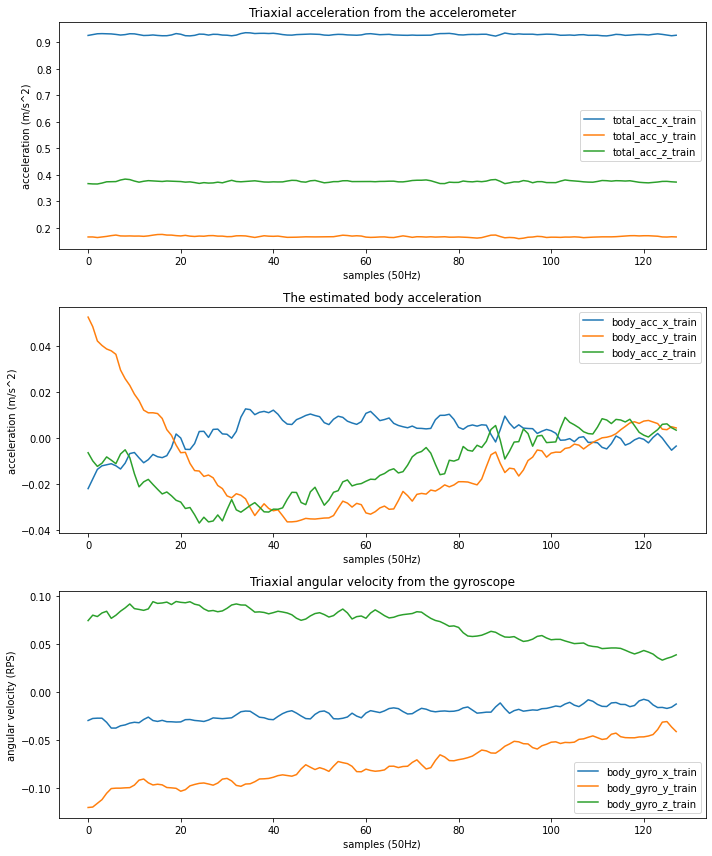

In [10]:
index = 28
print(train_y.iloc[index, 0])
fig, ax = plt.subplots(3,1,figsize=(10,12))
total_acc_x_train.iloc[index,:].plot(ax=ax[0])
total_acc_y_train.iloc[index,:].plot(ax=ax[0])
total_acc_z_train.iloc[index,:].plot(ax=ax[0])
ax[0].legend(["total_acc_x_train","total_acc_y_train","total_acc_z_train"])
ax[0].set_title("Triaxial acceleration from the accelerometer")
ax[0].set_ylabel("acceleration (m/s^2)")
ax[0].set_xlabel("samples (50Hz)")
body_acc_x_train.iloc[index,:].plot(ax=ax[1])
body_acc_y_train.iloc[index,:].plot(ax=ax[1])
body_acc_z_train.iloc[index,:].plot(ax=ax[1])
ax[1].legend(["body_acc_x_train","body_acc_y_train","body_acc_z_train"])
ax[1].set_title("The estimated body acceleration")
ax[1].set_ylabel("acceleration (m/s^2)")
ax[1].set_xlabel("samples (50Hz)")
body_gyro_x_train.iloc[index,:].plot(ax=ax[2])
body_gyro_y_train.iloc[index,:].plot(ax=ax[2])
body_gyro_z_train.iloc[index,:].plot(ax=ax[2])
ax[2].legend(["body_gyro_x_train","body_gyro_y_train","body_gyro_z_train"])
ax[2].set_title("Triaxial angular velocity from the gyroscope")
ax[2].set_ylabel("angular velocity (RPS)")
ax[2].set_xlabel("samples (50Hz)")
plt.tight_layout()


## EDA for features (with respect to activity)

Text(0.5, 0, '')

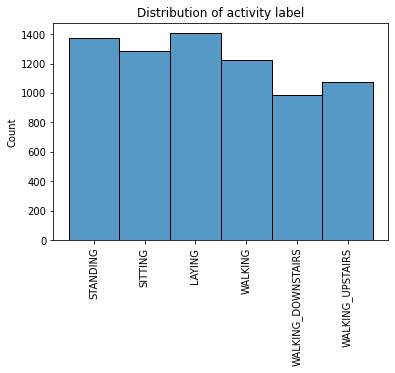

In [4]:
# get feature matrix
X_train_path = "/Users/yuqichengzhu/Desktop/Master Arbeit/Code/UCI HAR Dataset/train/X_train.txt"
col_names = pd.read_table("./UCI HAR Dataset/features_new.txt", delim_whitespace=True, header=None)
X_train = pd.read_table(X_train_path, delim_whitespace=True, names=col_names.iloc[:,1])

# get labels
y_train_path = "/Users/yuqichengzhu/Desktop/Master Arbeit/Code/UCI HAR Dataset/train/y_train.txt"
y_train = pd.read_table(y_train_path, delim_whitespace=True, header=None)

# Visualize label distribution
map_dict = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}
y_cate = y_train[0].map(map_dict)
sns.histplot(y_cate, discrete=True)
plt.xticks(rotation=90)
plt.title("Distribution of activity label")
plt.xlabel("")

## Feature Selection (Removing Features with Low Variance + L1 based feature selection)
Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the Lasso for regression, and of LogisticRegression and LinearSVC for classification.

/Users/yuqichengzhu/anaconda3/envs/GNNAL/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


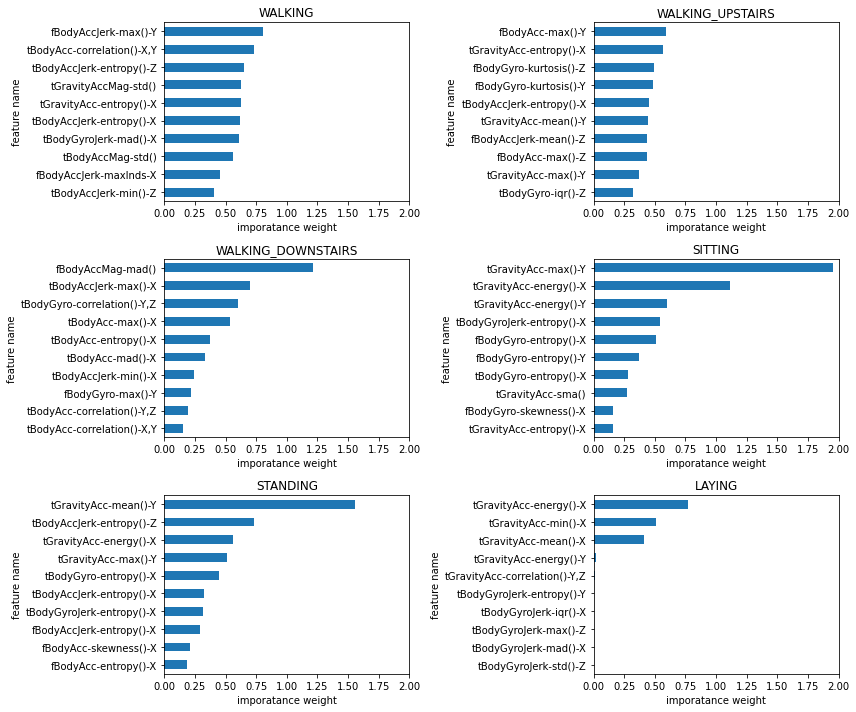

In [8]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Removing Features with Low Variance
thres = 0.9
selector = VarianceThreshold(threshold=(thres*(1-thres))).fit(np.array(X_train))
X_train_thres = selector.transform(np.array(X_train))
# get new column names
new_col_names = col_names[selector.get_support()].iloc[:,1]

# L1 based feature selection
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train_thres, np.ravel(np.array(y_train)))
importance = pd.DataFrame(data=lsvc.coef_, columns=new_col_names)
# importance.loc[:, (importance != 0).any(axis=0)]

# Get the importance weight for the top 10 features for each label
label_str = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
fig, ax = plt.subplots(3,2,figsize=(12,10))
count = 0
for i in range(3):
    for j in range(2):
        sorted_weight = importance.iloc[count,:].abs().sort_values(ascending=True)
        sorted_weight[-10:].plot.barh(ax=ax[i,j])
        ax[i,j].set_title(label_str[count])
        ax[i,j].set_ylabel("feature name")
        ax[i,j].set_xlabel("imporatance weight")
        ax[i,j].set_xlim([0,2])
        count += 1
plt.tight_layout()

## Distribution of the most important features with respect to labels
Do it after baseline code test (Active Learning + Few-Shot Learning)

<AxesSubplot:ylabel='Density'>

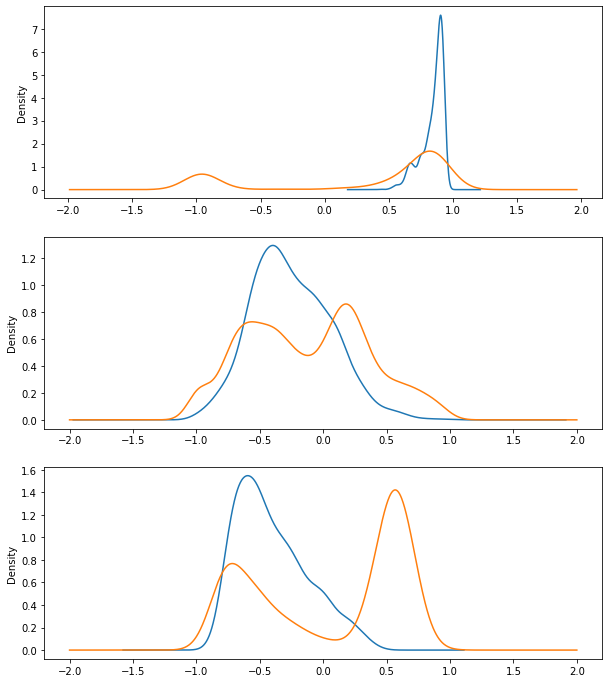

In [20]:
X_visual = X_train.copy()
X_visual["label"] = y_cate
fig, ax = plt.subplots(3,1,figsize=(10,12))
sorted_weight = importance.iloc[0,:].sort_values(ascending=True)
X_visual.loc[X_visual["label"]==label_str[0], sorted_weight.index[-1]].plot.density(ax=ax[0])
X_visual.loc[X_visual["label"]!=label_str[0], sorted_weight.index[-1]].plot.density(ax=ax[0])
